# Pairs / Spread Analysis

This notebook demonstrates a simple research workflow:
- Load and align close prices
- Compute rolling correlations (diagnostic)
- Estimate a time-varying hedge ratio (Kalman filter)
- Build the spread (residual) and compute an adaptive z-score
- Run basic diagnostics (half-life, optional ADF/KPSS)


In [16]:
# Notebook setup: ensure the repository root (with `src/`) is importable
from pathlib import Path
import sys

here = Path().resolve()
root = here if (here / "src").exists() else here.parent
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

import pandas as pd
import matplotlib.pyplot as plt

import src.core as core

# Pair configuration
ASSET_Y = "BTC-USD"
ASSET_X = "QQQ"

# Analysis parameters
CSV_PATH = root /"data"/"raw"/"prices.csv"  # update if needed
ALIGN = "inner"                  # recommended for 24/7 vs session-based markets
DELTA = 1e-5                      # Kalman: higher => faster adaptation
R = 1e-3                          # Kalman: higher => smoother estimates
ZSPAN = 45                  # EWM z-score span
ENTRY_Z = 2.0
EXIT_Z = 0.5


,BTC-USD,QQQ
Date,,
2025-11-21,85090.687500,590.070007
2025-11-24,88270.562500,605.159973
2025-11-25,87341.890625,608.890015
2025-11-26,90518.367188,614.270020
2025-11-28,90919.265625,619.250000


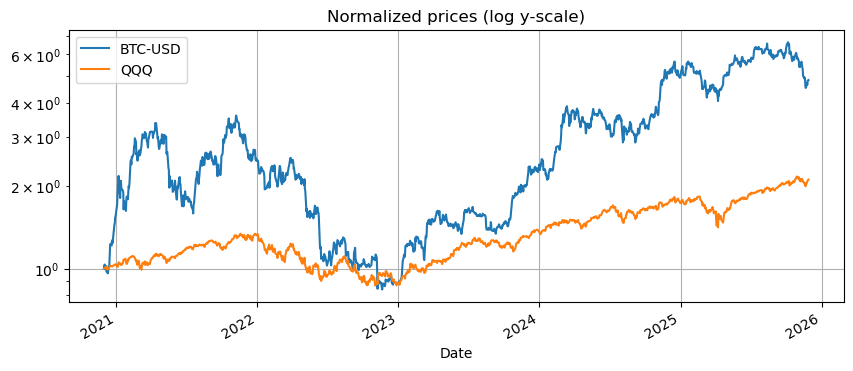

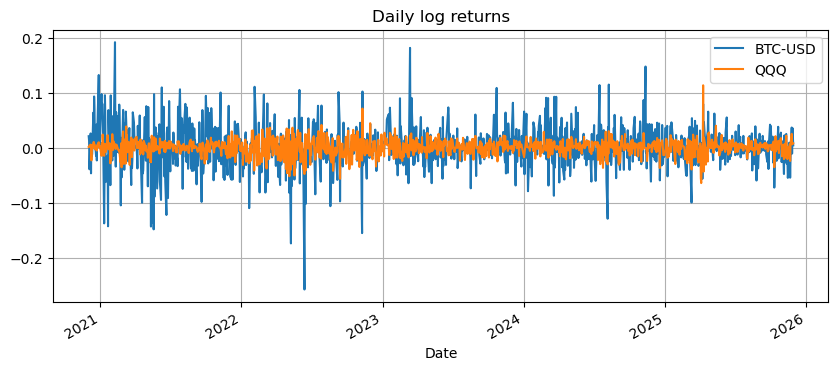

In [2]:
# 1) Load close prices (calendar alignment matters)
closes = core.load_and_prepare_closes(CSV_PATH, align=ALIGN)
display(closes.tail())

# Quick visual checks
base = closes / closes.iloc[0]
ax = base.plot(logy=True, figsize=(10, 4), title="Normalized prices (log y-scale)")
ax.grid(True)

returns = core.compute_log_returns(closes)
ax = returns.plot(figsize=(10, 4), title="Daily log returns")
ax.grid(True)


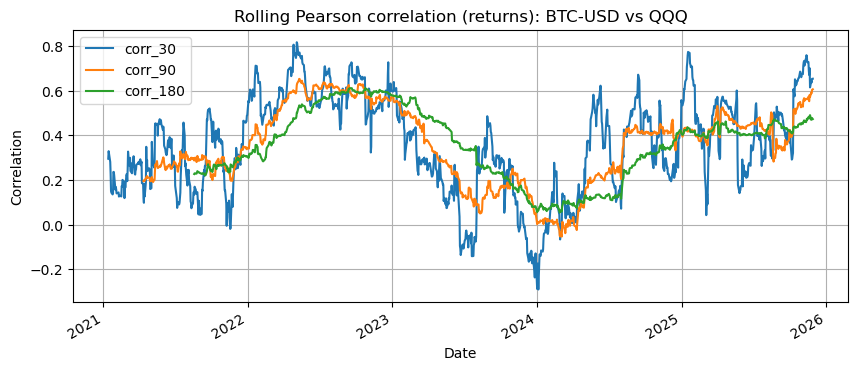

In [3]:
# 2) Rolling correlations (diagnostic only; not a cointegration test)
corr = core.rolling_correlation_dual(returns, ASSET_X, ASSET_Y, 30, 90, 180)
ax = corr.plot(figsize=(10, 4))
ax.set_title(f"Rolling Pearson correlation (returns): {ASSET_Y} vs {ASSET_X}")
ax.set_xlabel("Date")
ax.set_ylabel("Correlation")
ax.grid(True)


Latest alpha: 4.748962363497102
Latest beta: 1.0371144141888702


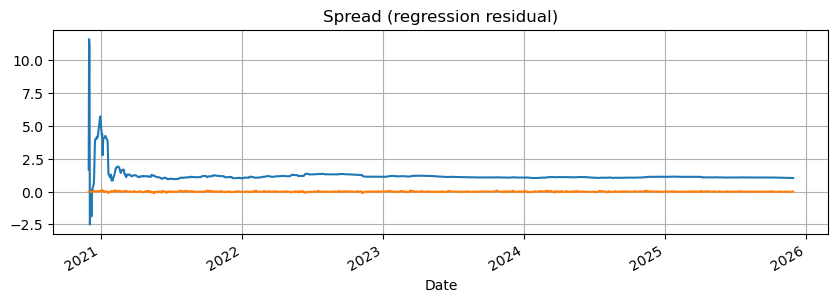

In [4]:
# 3) Time-varying hedge ratio and spread (residual) in log-price space
log_prices = core.compute_log_prices(closes)
k = core.kalman_hedge_ratio(log_prices, ASSET_Y, ASSET_X, delta=DELTA, r=R, include_intercept=True)

ax = k["beta"].plot(figsize=(10, 3), title="Time-varying hedge ratio (beta)")
ax.grid(True)

ax = k["spread"].plot(figsize=(10, 3), title="Spread (regression residual)")
ax.grid(True)

print("Latest alpha:", float(k["alpha"].dropna().iloc[-1]))
print("Latest beta:", float(k["beta"].dropna().iloc[-1]))


Half-life estimate (bars): 1.22
ADF: {'adf_stat': -18.58180853321225, 'pvalue': 2.0775713441026016e-30}
KPSS: {'kpss_stat': 0.0879150440489138, 'pvalue': 0.1}


C:\Users\siste\Desktop\CURSOS\Aprendizaje Trader Algo\Proyectos_trading_algoritmico\Cross_assets_pair_analyzer\src\core.py:339: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, pval, *_ = kpss(s, regression=regression, nlags=nlags)


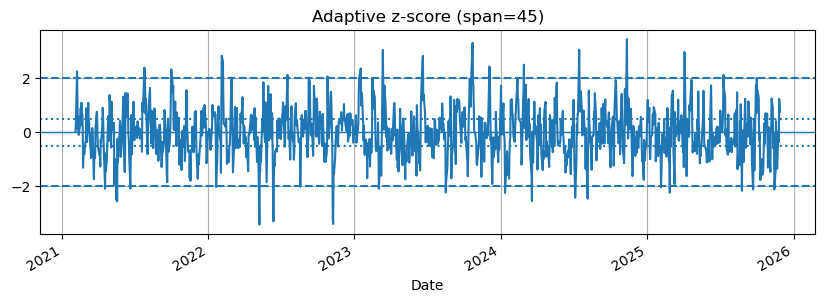

In [17]:
# 4) Adaptive z-score (EWM mean/std)
z = core.zscore_ewm(k["spread"], span=ZSPAN)

ax = z.plot(figsize=(10, 3), title=f"Adaptive z-score (span={ZSPAN})")
ax.axhline(ENTRY_Z, linestyle="--")
ax.axhline(-ENTRY_Z, linestyle="--")
ax.axhline(EXIT_Z, linestyle=":")
ax.axhline(-EXIT_Z, linestyle=":")
ax.axhline(0, linewidth=1)
ax.grid(True)

hl = core.half_life(k["spread"])
print(f"Half-life estimate (bars): {hl:.2f}")

# Optional: stationarity tests (requires statsmodels)
try:
    print("ADF:", core.adf_test(k["spread"]))
    print("KPSS:", core.kpss_test(k["spread"]))
except Exception as e:
    print("ADF/KPSS not available (install statsmodels):", e)
